# Parks BIAs | Comparing registry and final project descriptions

### Step 1: Load and clean the data

* remove punctuation  
* remove uppercase letters  
* remove numbers  
* tokenize into words  
* remove stop words (words with little meaning, e.g. the, a)


In [1]:
import pandas as pd
import re
import string
import numpy as np

In [2]:
# load the parks data that contains both registry and final project descriptions

data = pd.read_excel("data/processed/BIA_20select_Aug27_sorted.xlsx")
data.head(3)

,Unnamed: 0,title,reg_descript,final_descript,my_comments,field_unit,park,lat,lon,province,...,attach_ia,created,modified,created_by,modified_by,id,item_type,path,lang_check,wordcount
0,214,Biocontrol of Yellow Toadflax using Rhinusa pi...,Yellow toadflax is a widely distributed perenn...,This section describes the three potential loc...,The registry description presumes knowledge of...,Northern Prairies,Prince Albert National Park of Canada,53.56,106.073908,Saskatchewan,...,NaN,2020-01-23 16:26:14,2021-03-10 09:01:29,Fiona Moreland,Fiona Moreland,64,Item,sites/ImpactAssessment/Lists/DIA Tracking List,en,147
1,138,New Bridge Construction Across Mersey River at...,The proposed project will see the construction...,The proposed project will see the construction...,FKGL of 9 or FRE of 62; plain English (not bad...,Mainland Nova Scotia,Kejimkujik National Park of Canada,44.439512,-65.216088,Nova Scotia,...,NaN,2020-07-17 09:46:06,2020-11-12 13:13:06,Andrew Sharpe,Andrew Sharpe,141,Item,sites/ImpactAssessment/Lists/DIA Tracking List,en,109
2,210,Crean Channel Modification,"The Crean Lake Channel, which joins the 3rd He...","Crean channel, between Crean Lake and the Thir...",Grade 12 or FRE 53. No discrepancy. Minimal de...,Northern Prairies,Prince Albert National Park of Canada,54.10,106.16,Saskatchewan,...,NaN,2020-01-29 11:26:46,2020-05-20 16:05:40,Fiona Moreland,Fiona Moreland,68,Item,sites/ImpactAssessment/Lists/DIA Tracking List,en,132


In [3]:
# get rid of empty rows (not all final descriptions were available)

data = data[data.final_descript.notnull()].copy()
len(data)

10

In [4]:
# apply a first round of cleaning

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words that contain numbers'''
    text = re.sub('\w*\d\w*', '', str(text))
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    
    return text

round1 = lambda x: clean_text_round1(x)

In [5]:
# send cleaned data to new dataframe

reg_descript_clean = pd.DataFrame(data.reg_descript.apply(round1))
final_descript_clean = pd.DataFrame(data.final_descript.apply(round1))

data_clean = pd.concat([reg_descript_clean, final_descript_clean], axis=1)
data_clean["BIA_no"] = data.iloc[:, 0]
data_clean.head()

,reg_descript,final_descript,BIA_no
0,yellow toadflax is a widely distributed perenn...,this section describes the three potential loc...,214
1,the proposed project will see the construction...,the proposed project will see the construction...,138
2,the crean lake channel which joins the heart ...,crean channel between crean lake and the third...,210
3,red bay’s management plan identified strategi...,red bay national historic site rbnhs was estab...,50
4,in may the rabbit creek wildfire occurred in ...,objective the overall objective of this projec...,111


In [6]:
# reset index to start from 0

data_clean.reset_index(drop=True, inplace=True)

In [7]:
len(data_clean)

10

In [8]:
data_clean

,reg_descript,final_descript,BIA_no
0,yellow toadflax is a widely distributed perenn...,this section describes the three potential loc...,214
1,the proposed project will see the construction...,the proposed project will see the construction...,138
2,the crean lake channel which joins the heart ...,crean channel between crean lake and the third...,210
3,red bay’s management plan identified strategi...,red bay national historic site rbnhs was estab...,50
4,in may the rabbit creek wildfire occurred in ...,objective the overall objective of this projec...,111
5,the overall intent of this project is to repla...,the overall intent of this project is to repla...,184
6,the parks canada agency pca has proposed to co...,the parks canada agency pca has proposed to co...,161
7,parks canada is responsible for overseeing the...,parks canada is responsible for overseeing the...,126
8,grasslands national park is proposing to upgra...,grasslands national park gnp is proposing to u...,113
9,grasslands national park proposes to issue a l...,project being proposed is to graze domestic li...,205


### Step 2: Count vectorize lemmatized versions of the texts

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import nltk
nltk.download('punkt') # punctuation library
nltk.download('wordnet') # English vocab

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/whitneylight/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/whitneylight/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

cv = CountVectorizer(tokenizer=LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True,
                       token_pattern = r'\b[a-zA-Z]{3,}\b') # keeps words of 3 or more characters
                       


In [11]:
data_cv_reg = cv.fit_transform(data_clean.reg_descript)
data_dtm_reg = pd.DataFrame(data_cv_reg.toarray(), columns = cv.get_feature_names())
data_dtm_reg.index = data_clean.index
data_dtm_reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,ability,abutment,access,acquisition,act,active,activity,addition,additional,adjacent,...,wingwalls,wood,wooden,work,working,x,year,yellow,’,”
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,2,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,2,0
4,0,0,1,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
5,0,2,0,0,0,0,2,0,0,0,...,2,0,1,2,0,0,0,0,0,1
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
8,0,0,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data_cv_final = cv.fit_transform(data_clean.final_descript)
data_dtm_final = pd.DataFrame(data_cv_final.toarray(), columns = cv.get_feature_names())
data_dtm_final.index = data_clean.index
data_dtm_final

,abandoning,abovenoted,abutment,access,accessing,accommodate,according,account,acquisition,act,...,world,written,x,year,yellow,–,‘,’,“,”
0,0,1,0,2,0,0,0,0,0,0,...,0,1,0,0,4,5,0,1,0,0
1,0,0,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,2,0,1,0,0,0,0,3,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
5,0,0,9,1,0,0,1,1,0,1,...,0,0,0,0,0,0,1,4,1,2
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,4,0,1,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# transpose the data

data_reg_t = data_dtm_reg.transpose()
data_final_t = data_dtm_final.transpose()


In [14]:
# reduce to only rows where words are 3 characters long or longer
data_reg_t = data_reg_t[data_reg_t.index.map(len) > 2]
data_reg_t

,0,1,2,3,4,5,6,7,8,9
ability,1,0,0,0,0,0,0,0,0,0
abutment,0,1,0,0,0,2,0,0,0,0
access,0,0,0,0,1,0,0,0,2,0
acquisition,0,0,0,0,0,0,0,0,0,1
act,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
wooden,0,0,0,1,0,1,0,0,0,0
work,0,0,0,0,1,2,0,1,1,0
working,1,0,1,0,0,0,0,0,0,0
year,0,0,1,0,0,0,0,1,0,0


In [15]:
data_final_t = data_final_t[data_final_t.index.map(len) > 2]
data_final_t

,0,1,2,3,4,5,6,7,8,9
abandoning,0,0,0,0,0,0,0,1,0,0
abovenoted,1,0,0,0,0,0,0,0,0,0
abutment,0,4,0,0,0,9,0,0,0,0
access,2,0,0,0,1,1,0,0,4,0
accessing,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
working,0,0,1,0,0,0,0,0,0,0
world,0,0,0,2,0,0,0,0,0,0
written,1,0,0,0,0,0,0,0,0,0
year,0,0,0,0,0,0,0,1,0,0


In [16]:
# check for additional stop words
# get words (rows) that appear the most across all samples



### Step 3: Compare words in registry and final texts

#### Look at sample 0 (BIA_no 214)

In [17]:
sample_0 = pd.concat([data_reg_t.iloc[:, 0], # first col from registry text
                      data_final_t.iloc[:, 0]], # first col from final descript text 
                      axis = 1, # join columns
                      ignore_index=True).fillna(0) #convert NaN values to 0

sample_0.rename(columns = {0: 'reg', 1: 'final'}, inplace=True)
sample_0.head()

,reg,final
ability,1.0,0.0
abutment,0.0,0.0
access,0.0,2.0
acquisition,0.0,0.0
act,0.0,0.0


In [18]:
len(sample_0)

983

In [19]:
#ignore
# try a better (alternative) way of organizing the dataframe

#sample_0x = sample_0.copy()
#sample_0x.reset_index(inplace = True)
#sample_0x.rename(columns = {'index': 'word'})

In [20]:
# only include rows where the word occurred in at least one of the columns

sample_0 = sample_0[(sample_0['reg'] >= 1) | (sample_0['final'] >= 1)]
len(sample_0) # count the size of the 'bag of words' in sample 0

182

In [21]:
# words that occurred in both the registry and final description
print(sample_0[(sample_0['reg'] >= 1) & (sample_0['final'] >= 1)]) 
print(len(sample_0[(sample_0['reg'] >= 1) & (sample_0['final'] >= 1)]) )

            reg  final
agent       1.0    4.0
area        2.0    3.0
control     2.0    3.0
herbicide   1.0    1.0
invasive    1.0    3.0
large       1.0    1.0
late        1.0    1.0
location    2.0    3.0
native      1.0    1.0
occurred    1.0    1.0
pilosa      1.0    2.0
plant       2.0    1.0
rhinusa     1.0    1.0
site        1.0   15.0
specie      1.0    3.0
summer      1.0    2.0
toadflax    2.0    4.0
vegetation  1.0    1.0
yellow      2.0    4.0
19


In [22]:
# words that occurred in the final description but not the registry
pd.set_option('display.max_rows', None)
print(sample_0[(sample_0['reg'] == 0) & (sample_0['final'] >= 1)]) 

                reg  final
access          0.0    2.0
addition        0.0    1.0
damage          0.0    1.0
depending       0.0    1.0
disturbance     0.0    1.0
following       0.0    1.0
impact          0.0    1.0
include         0.0    2.0
issue           0.0    1.0
maintain        0.0    1.0
number          0.0    1.0
occur           0.0    1.0
owner           0.0    1.0
permission      0.0    1.0
possible        0.0    1.0
potential       0.0    3.0
proposed        0.0    3.0
purpose         0.0    2.0
section         0.0    1.0
spring          0.0    1.0
successfully    0.0    1.0
used            0.0    1.0
weed            0.0    2.0
work            0.0    1.0
abovenoted      0.0    1.0
action          0.0    2.0
adult           0.0    1.0
application     0.0    1.0
approximate     0.0    1.0
areal           0.0    1.0
availability    0.0    1.0
avoid           0.0    1.0
biocontrol      0.0    5.0
build           0.0    1.0
burning         0.0    1.0
characteristic  0.0    4.0
c

In [23]:
# words in both registry and final, as a percentage of all words used in the final project description

final_0 = 19 + 111
common_0 = 19
print(common_0 / final_0)

0.14615384615384616


It looks like the registry description captured 15% of the final description. However, this is a relative and subjective measure. 15% might be quite good.

In [24]:
# repeat for all 10 projects

# define function to make a project-level dataframe of registry and final descriptions

def make_df(project_number=0):
    
    df = pd.concat([data_reg_t.iloc[:, project_number], # grab project col from registry descrip df
                      data_final_t.iloc[:, project_number]], # grab project col from final descrip df
                      axis = 1, # join cols
                      ignore_index = True).fillna(0) # convert NaN values to 0
    
    df.rename(columns = {0: 'reg', 1: 'final'}, inplace = True)
    
    df = df[(df['reg'] >= 1) | (df['final'] >= 1)] # return only words that appeared in this project
    
    return df


In [25]:
# define function to calculate commons words / all words in final description as percentage

def percent_common(df):
    
    common_words = df[(df['reg'] >= 1) & (df['final'] >= 1)] 
    
    final_words = df[df['final'] >= 1]
    
    return len(common_words) / len(final_words) * 100


In [26]:
# test ... working!

project_0 = make_df(0)
percent_common(project_0)


14.615384615384617

In [27]:
results = []

for i in range(0,10):
    
    project_df = make_df(i)
    
    result = percent_common(project_df)
    
    results.append([result])

percent_data = pd.DataFrame(results, columns=['percent_common_words'])

In [28]:
percent_data

,percent_common_words
0,14.615385
1,34.862385
2,43.333333
3,45.138889
4,39.506173
5,20.253165
6,96.491228
7,58.041958
8,18.367347
9,29.457364


In [29]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import seaborn as sns

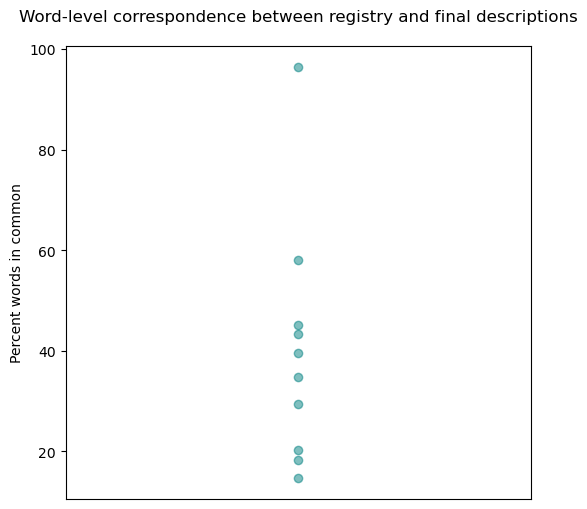

In [30]:
# make a graph of the percent common results

x = [1]*10

figure(figsize=(6, 6), dpi=100)

sns.regplot(x=x, y=percent_data['percent_common_words'], scatter_kws={"color":'teal', "alpha": 0.5})
#plt.scatter(x, percent_data['percent_common_words'])
plt.tick_params(bottom = False, labelbottom=False)
plt.title("Word-level correspondence between registry and final descriptions", pad=18)
plt.ylabel("Percent words in common")
plt.savefig("output/common_words.png")
plt.show()



#### Make wordclouds to compare registry and final descriptions.

Use the clean original texts from the data_clean df above. 

In [31]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

In [32]:
# initiate word cloud object
wc = WordCloud(stopwords = None, background_color = 'white', colormap = 'Dark2', 
              max_font_size = 150, random_state = 42)

In [33]:
# make wordclouds from the original texts 

data_clean.head()

,reg_descript,final_descript,BIA_no
0,yellow toadflax is a widely distributed perenn...,this section describes the three potential loc...,214
1,the proposed project will see the construction...,the proposed project will see the construction...,138
2,the crean lake channel which joins the heart ...,crean channel between crean lake and the third...,210
3,red bay’s management plan identified strategi...,red bay national historic site rbnhs was estab...,50
4,in may the rabbit creek wildfire occurred in ...,objective the overall objective of this projec...,111


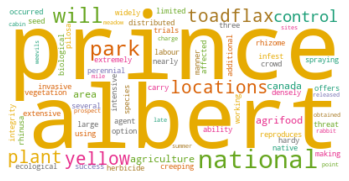

In [34]:
# registry text
cloud1 = wc.generate(data_clean.iloc[0,0])
plt.imshow(cloud1, interpolation = "bilinear")
plt.axis('off')
plt.show()

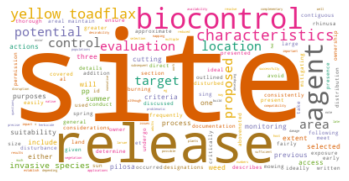

In [35]:
# final text
cloud2 = wc.generate(data_clean.iloc[0,1])
plt.imshow(cloud1, interpolation = "bilinear")
plt.axis('off')
plt.show()

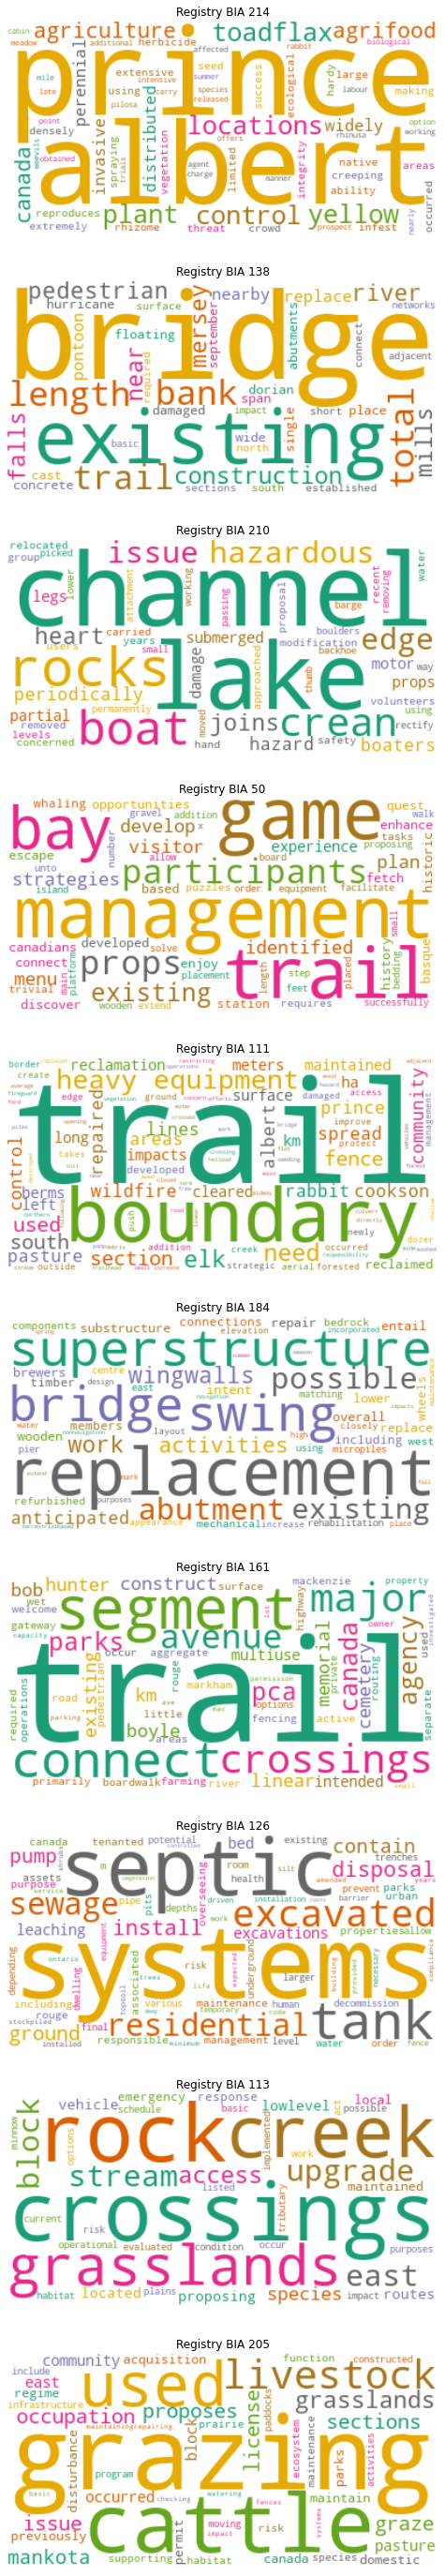

In [36]:
# print all registry text wordclouds

# include additional stop words
add_stopwords = ['will', 'park', 'area', 'site', 'sites','new', 'proposed', 'project', 'national', 's', 'n', 
                 'appendix', 'approximately', 'assessment', 'assessed', 'complete', 'location', 'meter', 'red', 
                 'use']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

wc = WordCloud(stopwords = stop_words, background_color = 'white', colormap = 'Dark2', 
              max_font_size = 150, random_state = 42)

plt.rcParams['figure.figsize'] = [25,50]

BIA_nos = ['Registry BIA 214', 'Registry BIA 138','Registry BIA 210', 'Registry BIA 50', 'Registry BIA 111',
          'Registry BIA 184', 'Registry BIA 161', 'Registry BIA 126', 'Registry BIA 113', 'Registry BIA 205']

for index, row in data_clean.iterrows():
    wc.generate(data_clean.reg_descript[index])
                
    plt.subplot(10, 1, index+1)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(BIA_nos[index])
    
#plt.show()
plt.savefig("output/registry_wordclouds.png")

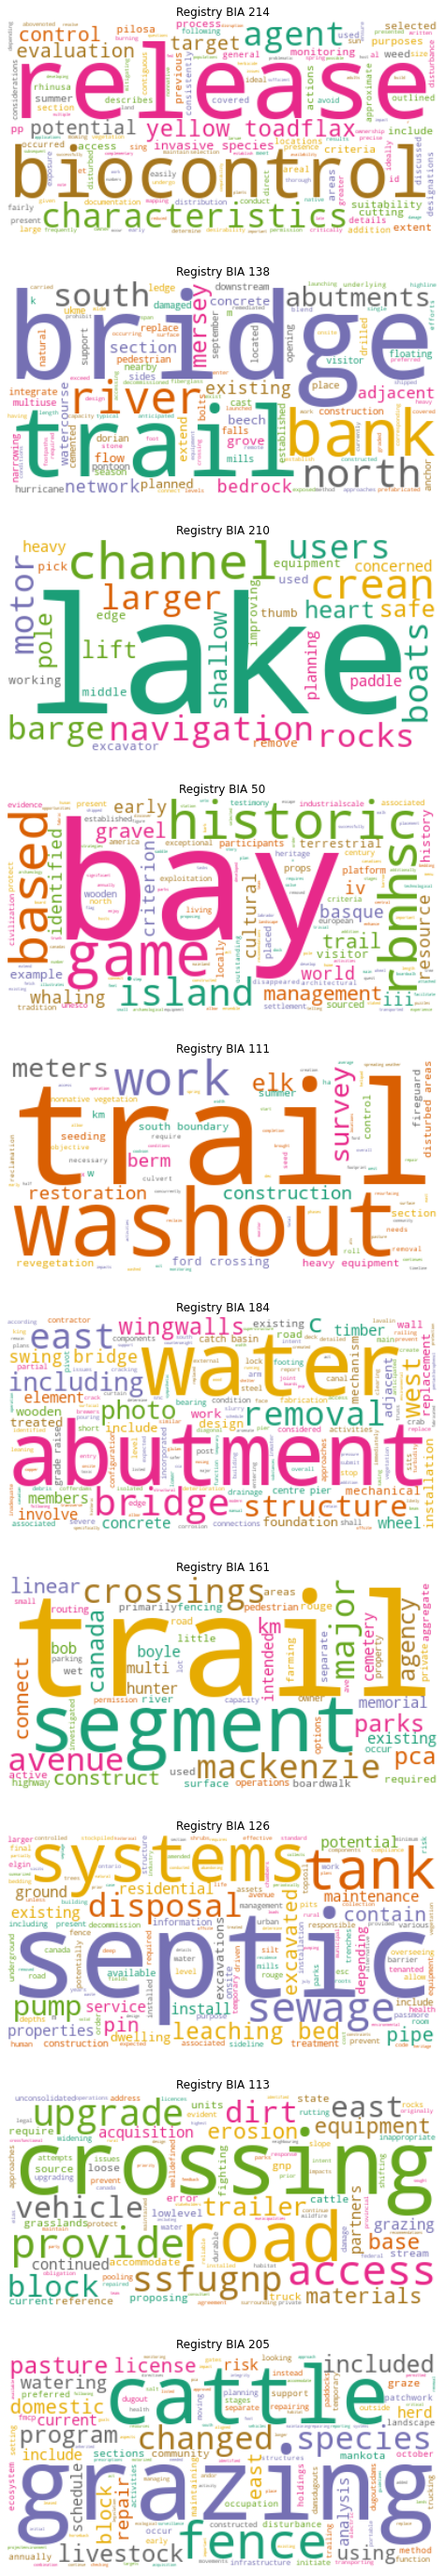

In [37]:
# now print final project description word clouds
plt.rcParams['figure.figsize'] = [25,50]

for index, row in data_clean.iterrows():
    wc.generate(data_clean.final_descript[index])
                
    plt.subplot(10, 1, index+1)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(BIA_nos[index])
    
#plt.show()
plt.savefig("output/final_wordclouds.png")